In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

In [2]:
#@title 2 agent env

class FrozenLakeMultiAgentEnv(gym.Env):
    """
    A multi-agent FrozenLake environment where two agents navigate a frozen grid.
    The agents receive a bonus reward if they reach the goal at the same time.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, grid_size=(5, 5), slip_prob=0.2, hole_prob=0.2, seed=None, collaboration_bonus=1.0):
        super(FrozenLakeMultiAgentEnv, self).__init__()
        self.grid_size = grid_size
        self.slip_prob = slip_prob  # Probability of slipping
        self.hole_prob = hole_prob  # Probability of each cell being a hole
        self.collaboration_bonus = collaboration_bonus  # Bonus reward for simultaneous goal arrival

        # Set seed for reproducibility
        if seed is not None:
            self.np_random = np.random.RandomState(seed)
            self.random_gen = random.Random(seed)
        else:
            self.np_random = np.random.RandomState()
            self.random_gen = random.Random()

        self.action_space = spaces.MultiDiscrete([4, 4])  # Actions for both agents (0: left, 1: down, 2: right, 3: up)
        self.observation_space = spaces.MultiDiscrete([grid_size[0] * grid_size[1], grid_size[0] * grid_size[1]])

        # Define start and goal positions
        self.agent1_start = (0, 0)
        self.agent2_start = (self.grid_size[0]-1, self.grid_size[1]-1)
        self.goal1 = (self.grid_size[0]-1, 0)
        self.goal2 = (self.grid_size[0]-1, 0)  # Même objectif que l'agent 1

        # Generate holes only once during initialization
        self.holes = self._generate_holes()

        # Initialize agent positions and states
        self.agent1_pos = None
        self.agent2_pos = None
        self.agent_done = None

        # Track if agents reached the goal (not just if they're done)
        self.reached_goal = None

        # Complete initialization with reset
        self.reset()

    def _path_exists(self, start, goal, holes):
        """Vérifie s'il existe un chemin entre start et goal en évitant les trous"""
        queue = [start]
        visited = {start}

        while queue:
            x, y = queue.pop(0)

            if (x, y) == goal:
                return True

            # Vérifier les 4 directions
            for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]:  # Gauche, Bas, Droite, Haut
                nx, ny = x + dx, y + dy

                if (0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1] and
                    (nx, ny) not in holes and (nx, ny) not in visited):
                    queue.append((nx, ny))
                    visited.add((nx, ny))

        return False

    def _generate_holes(self):
        """Generate holes once and ensure paths exist"""
        holes = set()
        max_holes = int(self.grid_size[0] * self.grid_size[1] * self.hole_prob)
        hole_candidates = [(i, j) for i in range(self.grid_size[0]) for j in range(self.grid_size[1])
                          if (i, j) not in [self.agent1_start, self.agent2_start, self.goal1, self.goal2]]

        # Shuffle candidates to avoid bias in hole selection
        self.random_gen.shuffle(hole_candidates)

        # Add holes randomly but check that a path exists after each addition
        for candidate in hole_candidates[:max_holes*2]:  # Try up to twice as many candidates
            if len(holes) >= max_holes:
                break

            # Temporarily add the hole
            holes.add(candidate)

            # Check if paths still exist for both agents
            path1 = self._path_exists(self.agent1_start, self.goal1, holes)
            path2 = self._path_exists(self.agent2_start, self.goal2, holes)

            if not (path1 and path2):
                # If no path, remove the hole
                holes.remove(candidate)

        return holes

    def reset(self, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
            # Note: This only affects the gym random state, not our holes

        # Reset agent positions to starting positions
        self.agent1_pos = self.agent1_start
        self.agent2_pos = self.agent2_start

        # Reset agent done states
        self.agent_done = [False, False]

        # Reset goal reaching states
        self.reached_goal = [False, False]

        return self.get_state(), {}

    def step(self, actions):
        # Track if agents were already done from previous steps
        if not hasattr(self, 'agent_done') or self.agent_done is None:
            self.agent_done = [False, False]

        if not hasattr(self, 'reached_goal') or self.reached_goal is None:
            self.reached_goal = [False, False]

        # Only move agents that aren't already done
        if not self.agent_done[0]:
            new_pos1 = self.move(self.agent1_pos, actions[0])
        else:
            new_pos1 = self.agent1_pos

        if not self.agent_done[1]:
            new_pos2 = self.move(self.agent2_pos, actions[1])
        else:
            new_pos2 = self.agent2_pos

        rewards = [0, 0]
        done = [False, False]
        truncated = [False, False]
        info = {"simultaneous_arrival": False}

        # Temporary flags to detect simultaneous goal arrival in this step
        just_reached_goal = [False, False]

        # Check agent 1 status if not already done
        if not self.agent_done[0]:
            if new_pos1 in self.holes:
                rewards[0] = 0
                self.agent_done[0] = True
                done[0] = True
            elif new_pos1 == self.goal1:
                rewards[0] = 1
                self.agent_done[0] = True
                done[0] = True
                self.reached_goal[0] = True
                just_reached_goal[0] = True
        else:
            # If agent was already done, keep the done flag set
            done[0] = True

        # Check agent 2 status if not already done
        if not self.agent_done[1]:
            if new_pos2 in self.holes:
                rewards[1] = 0
                self.agent_done[1] = True
                done[1] = True
            elif new_pos2 == self.goal2:
                rewards[1] = 1
                self.agent_done[1] = True
                done[1] = True
                self.reached_goal[1] = True
                just_reached_goal[1] = True
        else:
            # If agent was already done, keep the done flag set
            done[1] = True

        # Check if both agents reached the goal in this step (simultaneous arrival)
        if just_reached_goal[0] and just_reached_goal[1]:
            # Apply the collaboration bonus to both agents
            rewards[0] += self.collaboration_bonus
            rewards[1] += self.collaboration_bonus
            info["simultaneous_arrival"] = True

        self.agent1_pos = new_pos1
        self.agent2_pos = new_pos2

        return self.get_state(), rewards, done, truncated, info

    def move(self, position, action):
        if self.np_random.rand() < self.slip_prob:
            if action == 0:  # LEFT
                side_actions = [1, 3]  # UP, DOWN
            elif action == 1:  # DOWN
                side_actions = [0, 2]  # LEFT, RIGHT
            elif action == 2:  # RIGHT
                side_actions = [1, 3]  # UP, DOWN
            elif action == 3:  # UP
                side_actions = [0, 2]  # LEFT, RIGHT

            # Choose randomly between the two side directions
            action = self.np_random.choice(side_actions)  # Slip to a random action

        x, y = position
        if action == 0 and y > 0:
            y -= 1  # Left
        elif action == 1 and x < self.grid_size[0] - 1:
            x += 1  # Down
        elif action == 2 and y < self.grid_size[1] - 1:
            y += 1  # Right
        elif action == 3 and x > 0:
            x -= 1  # Up

        return (x, y)

    def get_state(self):
        return (self.agent1_pos[0] * self.grid_size[1] + self.agent1_pos[1],
                self.agent2_pos[0] * self.grid_size[1] + self.agent2_pos[1])

    def render(self, mode="human"):
        grid = np.full(self.grid_size, ".")
        for hole in self.holes:
            grid[hole] = "H"
        grid[self.goal1] = "G1"
        if self.goal2 != self.goal1:  # Only show G2 if it's different from G1
            grid[self.goal2] = "G2"
        grid[self.agent1_pos] = "A1"
        grid[self.agent2_pos] = "A2"

        print("\n".join(" ".join(row) for row in grid))
        print()

    def close(self):
        pass

In [2]:
#@title multi-n_agent_env

class FrozenLakeFlexibleAgentsEnv(gym.Env):
    """
    A multi-agent FrozenLake environment where multiple agents navigate a frozen grid.
    The agents receive a bonus reward if they reach the goal at the same time.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, num_agents=2, grid_size=(5, 5), slip_prob=0.2, hole_prob=0.2, seed=None, collaboration_bonus=1.0):
        super(FrozenLakeFlexibleAgentsEnv, self).__init__()
        self.grid_size = grid_size
        self.slip_prob = slip_prob  # Probability of slipping
        self.hole_prob = hole_prob  # Probability of each cell being a hole
        self.collaboration_bonus = collaboration_bonus  # Bonus reward for simultaneous goal arrival
        self.num_agents = num_agents

        # Set seed for reproducibility
        if seed is not None:
            self.np_random = np.random.RandomState(seed)
            self.random_gen = random.Random(seed)
        else:
            self.np_random = np.random.RandomState()
            self.random_gen = random.Random()

        # Actions for all agents (0: left, 1: down, 2: right, 3: up)
        self.action_space = spaces.MultiDiscrete([4] * num_agents)

        # Observation space for all agents (position of each agent)
        self.observation_space = spaces.MultiDiscrete([grid_size[0] * grid_size[1]] * num_agents)

        # Define goal position first (all agents share the same goal in this case)
        self.goal_pos = (self.grid_size[0]-1, 0)

        # Define starting positions for agents
        self.agent_starts = self._generate_start_positions()

        # Generate holes only once during initialization
        self.holes = self._generate_holes()

        # Initialize agent positions and states
        self.agent_positions = None
        self.agent_done = None
        self.reached_goal = None

        # Complete initialization with reset
        self.reset()

    def _generate_start_positions(self):
        """Generate starting positions for all agents"""
        positions = []

        # First agent starts at top-left
        positions.append((0, 0))

        # Last agent starts at bottom-right (if there are at least 2 agents)
        if self.num_agents > 1:
            positions.append((self.grid_size[0]-1, self.grid_size[1]-1))

        # For any additional agents, distribute them randomly
        cells = [(i, j) for i in range(self.grid_size[0]) for j in range(self.grid_size[1])
                if (i, j) not in positions and (i, j) != self.goal_pos]

        # If we need more positions
        if self.num_agents > 2:
            # Shuffle to get random positions
            self.random_gen.shuffle(cells)
            positions.extend(cells[:self.num_agents - 2])

        return positions

    def _path_exists(self, start, goal, holes):
        """Vérifie s'il existe un chemin entre start et goal en évitant les trous"""
        queue = [start]
        visited = {start}

        while queue:
            x, y = queue.pop(0)

            if (x, y) == goal:
                return True

            # Vérifier les 4 directions
            for dx, dy in [(0, -1), (1, 0), (0, 1), (-1, 0)]:  # Gauche, Bas, Droite, Haut
                nx, ny = x + dx, y + dy

                if (0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1] and
                    (nx, ny) not in holes and (nx, ny) not in visited):
                    queue.append((nx, ny))
                    visited.add((nx, ny))

        return False

    def _generate_holes(self):
        """Generate holes once and ensure paths exist for all agents"""
        holes = set()
        max_holes = int(self.grid_size[0] * self.grid_size[1] * self.hole_prob)

        # Exclude start positions and goal from hole candidates
        excluded_positions = set(self.agent_starts + [self.goal_pos])
        hole_candidates = [(i, j) for i in range(self.grid_size[0]) for j in range(self.grid_size[1])
                          if (i, j) not in excluded_positions]

        # Shuffle candidates to avoid bias in hole selection
        self.random_gen.shuffle(hole_candidates)

        # Add holes randomly but check that a path exists after each addition
        for candidate in hole_candidates[:max_holes*2]:  # Try up to twice as many candidates
            if len(holes) >= max_holes:
                break

            # Temporarily add the hole
            holes.add(candidate)

            # Check if paths still exist for all agents
            paths_exist = all(self._path_exists(start, self.goal_pos, holes) for start in self.agent_starts)

            if not paths_exist:
                # If any path doesn't exist, remove the hole
                holes.remove(candidate)

        return holes

    def reset(self, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
            # Note: This only affects the gym random state, not our holes

        # Reset agent positions to starting positions
        self.agent_positions = list(self.agent_starts)

        # Reset agent done states
        self.agent_done = [False] * self.num_agents

        # Reset goal reaching states
        self.reached_goal = [False] * self.num_agents

        return self.get_state(), {}

    def step(self, actions):
        # Ensure agent states are initialized
        if not hasattr(self, 'agent_done') or self.agent_done is None:
            self.agent_done = [False] * self.num_agents

        if not hasattr(self, 'reached_goal') or self.reached_goal is None:
            self.reached_goal = [False] * self.num_agents

        # Calculate new positions for agents that aren't already done
        new_positions = []
        for i in range(self.num_agents):
            if not self.agent_done[i]:
                new_positions.append(self.move(self.agent_positions[i], actions[i]))
            else:
                new_positions.append(self.agent_positions[i])

        rewards = [0] * self.num_agents
        done = [False] * self.num_agents
        truncated = [False] * self.num_agents
        info = {"simultaneous_arrival": False}

        # Temporary flags to detect simultaneous goal arrival in this step
        just_reached_goal = [False] * self.num_agents

        # Check status for each agent
        for i in range(self.num_agents):
            if not self.agent_done[i]:
                if new_positions[i] in self.holes:
                    rewards[i] = 0
                    self.agent_done[i] = True
                    done[i] = True
                elif new_positions[i] == self.goal_pos:
                    rewards[i] = 1
                    self.agent_done[i] = True
                    done[i] = True
                    self.reached_goal[i] = True
                    just_reached_goal[i] = True
            else:
                # If agent was already done, keep the done flag set
                done[i] = True

        # Check if multiple agents reached the goal in this step
        simultaneous_arrivals = sum(just_reached_goal)
        if simultaneous_arrivals >= 2:
            # Calculate progressive bonus based on number of simultaneous arrivals
            # More agents arriving together = higher bonus per agent
            progressive_bonus = self.collaboration_bonus * (simultaneous_arrivals - 1)

            # Apply the progressive collaboration bonus to all agents who arrived simultaneously
            for i in range(self.num_agents):
                if just_reached_goal[i]:
                    rewards[i] += progressive_bonus

            info["simultaneous_arrival"] = True
            info["num_simultaneous_arrivals"] = simultaneous_arrivals
            info["progressive_bonus"] = progressive_bonus

        # Update agent positions
        self.agent_positions = new_positions

        return self.get_state(), rewards, done, truncated, info

    def move(self, position, action):
        if self.np_random.rand() < self.slip_prob:
            if action == 0:  # LEFT
                side_actions = [1, 3]  # UP, DOWN
            elif action == 1:  # DOWN
                side_actions = [0, 2]  # LEFT, RIGHT
            elif action == 2:  # RIGHT
                side_actions = [1, 3]  # UP, DOWN
            elif action == 3:  # UP
                side_actions = [0, 2]  # LEFT, RIGHT

            # Choose randomly between the two side directions
            action = self.np_random.choice(side_actions)  # Slip to a random action

        x, y = position
        if action == 0 and y > 0:
            y -= 1  # Left
        elif action == 1 and x < self.grid_size[0] - 1:
            x += 1  # Down
        elif action == 2 and y < self.grid_size[1] - 1:
            y += 1  # Right
        elif action == 3 and x > 0:
            x -= 1  # Up

        return (x, y)

    def get_state(self):
        return tuple(pos[0] * self.grid_size[1] + pos[1] for pos in self.agent_positions)

    def render(self, mode="human"):
        grid = np.full(self.grid_size, ".")
        for hole in self.holes:
            grid[hole] = "H"
        grid[self.goal_pos] = "G"

        # Render each agent position
        for i, pos in enumerate(self.agent_positions):
            # If multiple agents are on the same position, just show the most recent one
            grid[pos] = f"A{i+1}"

        print("\n".join(" ".join(row) for row in grid))
        print()

    def close(self):
        pass

In [4]:
env=FrozenLakeFlexibleAgentsEnv(num_agents=2, grid_size=(5, 5), slip_prob=0.2, hole_prob=0.2, seed=None, collaboration_bonus=1.0)
env.render()

A . . . .
H H . . .
. . H . .
H . H . .
G . . . A



In [5]:
# Register environment
gym.envs.registration.register(
    id="FrozenLakeMultiAgent-v0",
    entry_point=FrozenLakeMultiAgentEnv,
)

# Example usage
env = FrozenLakeMultiAgentEnv()
obs, _ = env.reset()
env.render()
print("first_obs",obs)
done = [False,False]
while not all(done):
    actions = env.action_space.sample()  # Random actions for both agents
    obs, rewards, done, _, _ = env.step(actions)
    print(actions)
    print(obs)
    env.render()
    print(f"Rewards: {rewards}")

A . . . .
. . H H .
. . H . .
. . . H .
G . H . A

first_obs (0, 24)
[3 0]
(0, 23)
A . . . .
. . H H .
. . H . .
. . . H .
G . H A .

Rewards: [0, 0]
[1 1]
(5, 22)
. . . . .
A . H H .
. . H . .
. . . H .
G . A . .

Rewards: [0, 0]
[2 3]
(6, 22)
. . . . .
. A H H .
. . H . .
. . . H .
G . A . .

Rewards: [0, 0]
[2 1]
(11, 22)
. . . . .
. . H H .
. A H . .
. . . H .
G . A . .

Rewards: [0, 0]
[3 3]
(6, 22)
. . . . .
. A H H .
. . H . .
. . . H .
G . A . .

Rewards: [0, 0]
[3 0]
(1, 22)
. A . . .
. . H H .
. . H . .
. . . H .
G . A . .

Rewards: [0, 0]
[1 2]
(6, 22)
. . . . .
. A H H .
. . H . .
. . . H .
G . A . .

Rewards: [0, 0]
[1 3]
(11, 22)
. . . . .
. . H H .
. A H . .
. . . H .
G . A . .

Rewards: [0, 0]
[0 1]
(16, 22)
. . . . .
. . H H .
. . H . .
. A . H .
G . A . .

Rewards: [0, 0]
[2 1]
(17, 22)
. . . . .
. . H H .
. . H . .
. . A H .
G . A . .

Rewards: [0, 0]
[0 1]
(16, 22)
. . . . .
. . H H .
. . H . .
. A . H .
G . A . .

Rewards: [0, 0]
[0 1]
(11, 22)
. . . . .
. . H H .


In [6]:
#@title Qagent

class QAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0,
                 min_exploration_rate=0.01, exploration_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size

        # Initialisation de la table Q avec des zéros
        self.q_table = np.zeros((state_size, action_size))

        # Paramètres d'apprentissage
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.min_epsilon = min_exploration_rate
        self.epsilon_decay = exploration_decay


    def get_action(self, state):
        if random.random() < self.epsilon:
            # Action aléatoire (exploration)
            return random.randint(0, self.action_size - 1)
        else:
            # Action optimale selon la table Q (exploitation)
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        # Mise à jour de la table Q selon l'algorithme Q-learning
        # Q(s,a) = Q(s,a) + α * [r + γ * max Q(s',a') - Q(s,a)]

        # Si l'épisode est terminé, la valeur future est 0
        if done:
            future_q_value = 0
        else:
            future_q_value = np.max(self.q_table[next_state])

        # Calcul du target Q-value
        target = reward + self.gamma * future_q_value

        # Mise à jour de la valeur Q pour l'état et l'action actuels
        current = self.q_table[state, action]
        self.q_table[state, action] = current + self.lr * (target - current)

    def decay_epsilon(self):
        # Réduire epsilon progressivement pour favoriser l'exploitation au fil du temps
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)


# class MultiAgentQLearning:
#     def __init__(self, env, n_agents):
#         self.env = env
#         self.agents = [QAgent(...) for _ in range(n_agents)]

#     def train(self, episodes):
#         # Logique d'entraînement pour plusieurs agents

Épisode 1000/10000, Taux de réussite sur les 100 derniers épisodes: 0.53, Epsilon: 0.3676954247709635
Épisode 2000/10000, Taux de réussite sur les 100 derniers épisodes: 0.86, Epsilon: 0.1351999253974994
Épisode 3000/10000, Taux de réussite sur les 100 derniers épisodes: 0.95, Epsilon: 0.05
Épisode 4000/10000, Taux de réussite sur les 100 derniers épisodes: 0.93, Epsilon: 0.05
Épisode 5000/10000, Taux de réussite sur les 100 derniers épisodes: 0.90, Epsilon: 0.05
Épisode 6000/10000, Taux de réussite sur les 100 derniers épisodes: 0.96, Epsilon: 0.05
Épisode 7000/10000, Taux de réussite sur les 100 derniers épisodes: 0.94, Epsilon: 0.05
Épisode 8000/10000, Taux de réussite sur les 100 derniers épisodes: 0.97, Epsilon: 0.05
Épisode 9000/10000, Taux de réussite sur les 100 derniers épisodes: 0.96, Epsilon: 0.05
Épisode 10000/10000, Taux de réussite sur les 100 derniers épisodes: 0.92, Epsilon: 0.05


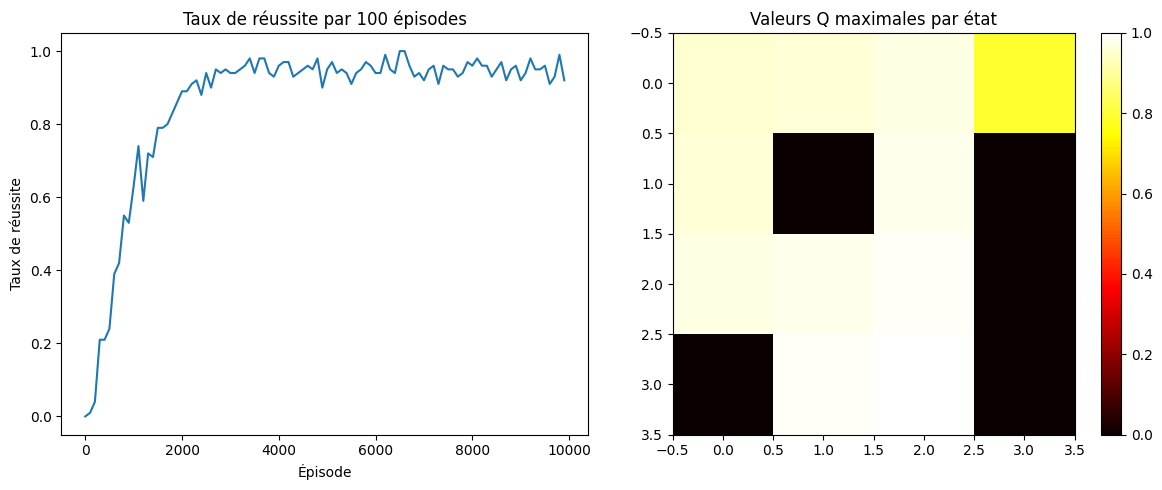

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
def test_qagent_frozen_lake():
    # Créer l'environnement FrozenLake
    env = gym.make('FrozenLake-v1', is_slippery=False)

    # Initialiser l'agent
    state_size = env.observation_space.n  # Nombre d'états possibles
    action_size = env.action_space.n      # Nombre d'actions possibles

    learning_rate=0.1
    discount_factor=0.99
    exploration_rate=1.0
    min_exploration_rate=0.05
    exploration_decay=0.999

    agent = QAgent(state_size, action_size,learning_rate=learning_rate, discount_factor=discount_factor,
                   exploration_rate=exploration_rate,
                 min_exploration_rate=min_exploration_rate, exploration_decay=exploration_decay)

    # Paramètres d'entraînement
    episodes = 10000
    max_steps = 100

    # Suivi des performances
    rewards_per_episode = []
    success_history = []  # Garder trace des succès (1) ou échecs (0)

    # Entraînement
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False

        for step in range(max_steps):
            # Choisir une action
            action = agent.get_action(state)

            # Exécuter l'action
            next_state, reward, done, truncated, _ = env.step(action)

            # Mettre à jour la table Q
            agent.update(state, action, reward, next_state, done)

            # Mise à jour de l'état et de la récompense
            state = next_state
            total_reward += reward

            if done or truncated:
                break

        # Enregistrer les résultats
        rewards_per_episode.append(total_reward)
        success_history.append(1 if total_reward > 0 else 0)

        # Réduire epsilon
        agent.decay_epsilon()

        # Afficher la progression
        if (episode + 1) % 1000 == 0:
            success_rate = sum(success_history[-100:]) / 100
            print(f"Épisode {episode + 1}/{episodes}, Taux de réussite sur les 100 derniers épisodes: {success_rate:.2f}, Epsilon: {agent.epsilon}")

    # Calculer le taux de réussite moyen par fenêtre de 100 épisodes
    window_size = 100
    success_rates = []
    for i in range(0, episodes, window_size):
        if i + window_size <= episodes:
            window_success = sum(success_history[i:i+window_size]) / window_size
            success_rates.append(window_success)

    # Tracer les résultats
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, episodes, window_size), success_rates)
    plt.title('Taux de réussite par 100 épisodes')
    plt.xlabel('Épisode')
    plt.ylabel('Taux de réussite')

    plt.subplot(1, 2, 2)
    plt.imshow(agent.q_table.reshape(4, 4, 4).max(axis=2), cmap='hot')
    plt.colorbar()
    plt.title('Valeurs Q maximales par état')

    plt.tight_layout()
    plt.savefig('qagent_results.png')
    plt.show()

    # Tester la politique apprise
    # print("\nTest de la politique apprise:")
    # test_episodes = 10
    # for episode in range(test_episodes):
    #     state, _ = env.reset()
    #     done = False
    #     truncated = False

    #     print(f"\nÉpisode de test {episode + 1}:")
    #     env.render()

    #     steps = 0
    #     while not (done or truncated) and steps < max_steps:
    #         # Utiliser la politique apprise (sans exploration)
    #         action = np.argmax(agent.q_table[state])
    #         next_state, reward, done, truncated, _ = env.step(action)

    #         # Afficher l'état
    #         env.render()

    #         print(f"Action: {action}, Récompense: {reward}")

    #         state = next_state
    #         steps += 1

    #     if reward > 0:
    #         print("Succès!")
    #     else:
    #         print("Échec!")

    # env.close()
    # return agent

if __name__ == "__main__":
    test_qagent_frozen_lake()

In [8]:
#@title visu_collab
env = gym.make('FrozenLake-v1', is_slippery=True, )
def visu_collab(env):
  print("Visualisation de l'environnement FrozenLake:")
  state, _ = env.reset()

  # Récupérer la description de l'environnement
  desc = env.unwrapped.desc.copy().tolist()

  # Convertir les bytes en string pour une meilleure lisibilité
  grid = []
  for row in desc:
      grid_row = []
      for cell in row:
          grid_row.append(cell.decode('utf-8'))
      grid.append(grid_row)

  # Afficher la grille
  print("Grille de l'environnement:")
  for row in grid:
      print(" ".join(row))

  print("\nLégende: S=Start, F=Frozen(sol gelé), H=Hole(trou), G=Goal(objectif)")
  print("Actions: 0=gauche, 1=bas, 2=droite, 3=haut\n")

In [9]:
env = gym.make('FrozenLake-v1', is_slippery=False)

visu_collab(env)

Visualisation de l'environnement FrozenLake:
Grille de l'environnement:
S F F F
F H F H
F F F H
H F F G

Légende: S=Start, F=Frozen(sol gelé), H=Hole(trou), G=Goal(objectif)
Actions: 0=gauche, 1=bas, 2=droite, 3=haut



In [10]:
env.reset()
visu_collab(env)

Visualisation de l'environnement FrozenLake:
Grille de l'environnement:
S F F F
F H F H
F F F H
H F F G

Légende: S=Start, F=Frozen(sol gelé), H=Hole(trou), G=Goal(objectif)
Actions: 0=gauche, 1=bas, 2=droite, 3=haut



In [11]:
#@title multiagent env test
#Register environment

gym.envs.registration.register(
    id="FrozenLakeMultiAgent-v0",
    entry_point=FrozenLakeMultiAgentEnv,
    kwargs={"grid_size": (5, 5), "slip_prob": 0.2, "hole_prob": 0.2}
)

# Example usage
env = FrozenLakeMultiAgentEnv(grid_size=(4, 4), slip_prob=0.0, hole_prob=0.0)
obs, _ = env.reset()
env.render()

episode_done = False
while not episode_done:
    actions = env.action_space.sample()  # Random actions for both agents
    obs, rewards, done, truncated, info = env.step(actions)
    print(f"Actions: {actions}")
    print(f"Observations: {obs}")
    env.render()
    print(f"Rewards: {rewards}")
    print(f"Done: {done}")

    # Episode ends when both agents are done or either agent is done (your choice)
    episode_done = all(done)  # Changed to all(done) to wait for both agents to finish

A . . .
. . . .
. . . .
G . . A

Actions: [2 3]
Observations: (1, 11)
. A . .
. . . .
. . . A
G . . .

Rewards: [0, 0]
Done: [False, False]
Actions: [1 3]
Observations: (5, 7)
. . . .
. A . A
. . . .
G . . .

Rewards: [0, 0]
Done: [False, False]
Actions: [0 0]
Observations: (4, 6)
. . . .
A . A .
. . . .
G . . .

Rewards: [0, 0]
Done: [False, False]
Actions: [3 1]
Observations: (0, 10)
A . . .
. . . .
. . A .
G . . .

Rewards: [0, 0]
Done: [False, False]
Actions: [3 1]
Observations: (0, 14)
A . . .
. . . .
. . . .
G . A .

Rewards: [0, 0]
Done: [False, False]
Actions: [3 1]
Observations: (0, 14)
A . . .
. . . .
. . . .
G . A .

Rewards: [0, 0]
Done: [False, False]
Actions: [3 2]
Observations: (0, 15)
A . . .
. . . .
. . . .
G . . A

Rewards: [0, 0]
Done: [False, False]
Actions: [1 0]
Observations: (4, 14)
. . . .
A . . .
. . . .
G . A .

Rewards: [0, 0]
Done: [False, False]
Actions: [0 2]
Observations: (4, 15)
. . . .
A . . .
. . . .
G . . A

Rewards: [0, 0]
Done: [False, False]
Action

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment FrozenLakeMultiAgent-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [12]:
#@title IQL

from tqdm import tqdm
class IndependentQLearning:
    """
    Implémentation de Q-Learning indépendant (IQL) pour les environnements multi-agents.
    Chaque agent apprend de manière indépendante sans prendre en compte les autres agents.
    """
    def __init__(self, env, n_agents=2, learning_rate=0.1, discount_factor=0.99,
                 exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay=0.999):
        self.env = env

        # Obtenir les tailles des espaces d'état et d'action pour chaque agent
        # Pour FrozenLakeMultiAgentEnv, state_size est la taille totale de la grille pour chaque agent
        grid_size = env.grid_size
        state_size = grid_size[0] * grid_size[1]
        action_size = 4  # 0: gauche, 1: bas, 2: droite, 3: haut

        # Créer un agent Q pour chaque agent dans l'environnement
        self.agents = [
            QAgent(state_size, action_size, learning_rate, discount_factor,
                   exploration_rate, min_exploration_rate, exploration_decay)
            for _ in range(n_agents)
        ]

        self.n_agents = n_agents

    def train(self, episodes=10000, max_steps=100, verbose=True):
      """
      Entraîne les agents de manière indépendante dans l'environnement multi-agent.

      Args:
          episodes: Nombre total d'épisodes d'entraînement
          max_steps: Nombre maximum d'étapes par épisode
          verbose: Si True, affiche la progression de l'entraînement

      Returns:
          Historique des récompenses et des taux de réussite par épisode
      """
      rewards_history = []
      rewards_rates = [[] for _ in range(self.n_agents)]  # Remplace success_rates
      episode_steps = []

      if verbose:
          episodes_iter = tqdm(range(episodes))
      else:
          episodes_iter = range(episodes)

      for episode in episodes_iter:
          # Réinitialiser l'environnement
          states, _ = self.env.reset()
          episode_rewards = [0] * self.n_agents
          dones = [False] * self.n_agents

          for step in range(max_steps):
              # Chaque agent choisit une action de manière indépendante
              actions = [
                  self.agents[i].get_action(states[i])
                  for i in range(self.n_agents)
              ]

              # Exécuter les actions dans l'environnement
              next_states, rewards, new_dones, truncated, _ = self.env.step(actions)

              # Mettre à jour les tables Q pour chaque agent de manière indépendante
              for i in range(self.n_agents):
                  # Ne mettre à jour que si l'agent n'est pas déjà terminé
                  if not dones[i]:
                      self.agents[i].update(
                          states[i], actions[i], rewards[i], next_states[i], new_dones[i]
                      )
                      episode_rewards[i] += rewards[i]

              # Mettre à jour les états et les drapeaux terminés
              states = next_states
              dones = new_dones

              # Sortir de la boucle si tous les agents ont terminé
              if all(dones) or all(truncated):
                  break

          # Enregistrer les résultats de l'épisode
          rewards_history.append(episode_rewards)
          episode_steps.append(step + 1)

          # Enregistrer les récompenses pour chaque agent au lieu des succès
          for i in range(self.n_agents):
              rewards_rates[i].append(episode_rewards[i])

          # Réduire epsilon pour chaque agent
          for agent in self.agents:
              agent.decay_epsilon()

          # Afficher la progression
          if verbose and (episode + 1) % (episodes // 10) == 0:
              reward_window = 100
              recent_rewards = [
                  np.mean(rewards_rates[i][-min(reward_window, len(rewards_rates[i])):])
                  for i in range(self.n_agents)
              ]

              print(f"Épisode {episode + 1}/{episodes}, "
                    f"Récompenses moyennes agents: {[f'{reward:.2f}' for reward in recent_rewards]}, "
                    f"Epsilon: {self.agents[0].epsilon:.4f}")

      return {
          'rewards': rewards_history,
          'rewards_rates': rewards_rates,  # Remplacé 'success_rates' par 'rewards_rates'
          'steps': episode_steps
      }

    def render_policy(self):
        """
        Affiche la politique apprise pour chaque agent
        """
        for agent_idx, agent in enumerate(self.agents):
            print(f"\nPolitique de l'agent {agent_idx + 1}:")
            grid_size = self.env.grid_size
            policy = np.argmax(agent.q_table, axis=1).reshape(grid_size)

            # Utiliser des symboles pour représenter les actions
            action_symbols = ['←', '↓', '→', '↑']

            for i in range(grid_size[0]):
                for j in range(grid_size[1]):
                    state_idx = i * grid_size[1] + j
                    print(f" {action_symbols[policy[i, j]]} ", end='')
                print()


In [13]:
def evaluate_policy(agent, env, n_episodes=100, max_steps=100):
    """
    Évalue la performance de la politique apprise, tenant compte du bonus de collaboration.
    Compatible avec IndependentQLearning et CentralizedQLearning.

    Args:
        agent: Instance IndependentQLearning ou CentralizedQLearning contenant les agents entraînés
        env: Environnement FrozenLakeMultiAgentEnv
        n_episodes: Nombre d'épisodes d'évaluation
        max_steps: Nombre maximum d'étapes par épisode

    Returns:
        dict: Dictionnaire contenant les statistiques d'évaluation
    """
    success_rates = [0] * agent.n_agents
    steps_when_reached = [[] for _ in range(agent.n_agents)]  # Pour enregistrer l'étape exacte où l'objectif est atteint
    rewards_total = [[] for _ in range(agent.n_agents)]
    collaborative_successes = 0  # Compteur pour les succès collaboratifs

    print(f"\nÉvaluation de la politique sur {n_episodes} épisodes...")

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = [False] * agent.n_agents
        episode_rewards = [0] * agent.n_agents
        reached_goal = [False] * agent.n_agents  # Pour suivre si l'agent a atteint l'objectif
        collaboration_this_episode = False

        for step in range(max_steps):
            # Utiliser la politique apprise (sans exploration)
            if hasattr(agent, 'agents'):  # IndependentQLearning
                actions = [np.argmax(agent.agents[i].q_table[state[i]]) for i in range(agent.n_agents)]
            else:  # CentralizedQLearning
                # Nous n'utilisons pas la méthode get_action pour éviter l'exploration
                joint_state = agent.state_to_index(state)
                # Modification ici: utiliser directement agent.q_table au lieu de agent.central_agent.q_table
                joint_action = np.argmax(agent.q_table[joint_state])
                actions = agent.index_to_actions(joint_action)

            # Exécuter les actions
            next_state, rewards, done, _, info = env.step(actions)

            # Vérifier s'il y a eu une arrivée simultanée
            if 'simultaneous_arrival' in info and info['simultaneous_arrival']:
                collaboration_this_episode = True

            # Accumuler les récompenses
            for i in range(agent.n_agents):
                episode_rewards[i] += rewards[i]
                # Considérer qu'un agent a atteint l'objectif s'il reçoit une récompense positive
                if rewards[i] > 0 and not reached_goal[i]:  # S'il atteint l'objectif pour la première fois
                    reached_goal[i] = True
                    steps_when_reached[i].append(step + 1)  # Enregistrer l'étape exacte

            # Si tous les agents ont terminé, sortir de la boucle
            if all(done):
                break

            state = next_state

        # Incrémenter le compteur de succès collaboratifs
        if collaboration_this_episode:
            collaborative_successes += 1

        # Enregistrer les statistiques
        for i in range(agent.n_agents):
            # Un agent réussit s'il a atteint l'objectif
            success_rates[i] += 1 if reached_goal[i] else 0

            # Enregistrer la récompense totale
            rewards_total[i].append(episode_rewards[i])

    # Calculer les statistiques finales
    for i in range(agent.n_agents):
        success_rates[i] /= n_episodes

    # Calculer le taux de collaboration
    collaboration_rate = collaborative_successes / n_episodes

    # Préparer les résultats
    eval_results = {
        'success_rates': success_rates,
        'avg_steps_to_goal': [np.mean(steps) if steps else float('nan') for steps in steps_when_reached],
        'avg_rewards': [np.mean(rewards) for rewards in rewards_total],
        'collaboration_rate': collaboration_rate
    }

    # Afficher les résultats
    print("\nRésultats de l'évaluation:")
    for i in range(agent.n_agents):
        print(f"Agent {i+1}:")
        print(f"  - Taux de réussite: {success_rates[i]*100:.2f}%")
        if steps_when_reached[i]:
            print(f"  - Nombre moyen d'étapes (succès): {eval_results['avg_steps_to_goal'][i]:.2f}")
        else:
            print(f"  - Nombre moyen d'étapes (succès): N/A (aucun succès)")
        print(f"  - Récompense moyenne: {eval_results['avg_rewards'][i]:.4f}")

    print(f"\nTaux de collaboration: {collaboration_rate*100:.2f}%")

    return eval_results

In [14]:
def test_independent_learning(env,n_agents=2,
                              learning_rate = 0.3,
                              max_episodes=50000,
                              discount_factor = 0.99,
                              exploration_rate = 1.0,
                              min_exploration_rate = 0.05,
                              exploration_decay = 0.99995,
                              window_size=200):

    # Créer l'environnement

    # Visualiser l'environnement initial
    print("Environnement initial:")
    env.render()

    # # Paramètres d'apprentissage
    # learning_rate = 0.3
    # discount_factor = 0.99
    # exploration_rate = 1.0
    # min_exploration_rate = 0.05
    # exploration_decay = 0.99995

    # Créer l'instance d'apprentissage indépendant
    iql = IndependentQLearning(
        env,
        n_agents=n_agents,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration_rate=min_exploration_rate,
        exploration_decay=exploration_decay
    )

    # Entraîner les agents
    print("\nDébut de l'entraînement...")
    results = iql.train(episodes=max_episodes, max_steps=100)

    # Afficher les politiques apprises
    print("\nPolitiques apprises:")
    iql.render_policy()

    # Visualiser les résultats
    plt.figure(figsize=(15, 10))

    # Tracer les taux de récompense pour chaque agent
    # window_size = 200
    for i in range(iql.n_agents):
        plt.subplot(iql.n_agents, 1, i+1)

        # Calculer les récompenses moyennes par fenêtre
        rewards_rates = results['rewards_rates'][i]  # Utiliser rewards_rates au lieu de success_rates
        rewards_rates_smoothed = []

        for j in range(0, len(rewards_rates), window_size):
            if j + window_size <= len(rewards_rates):
                rewards_rates_smoothed.append(np.mean(rewards_rates[j:j+window_size]))

        plt.plot(range(0, len(rewards_rates_smoothed) * window_size, window_size), rewards_rates_smoothed)
        plt.title(f"Agent {i+1} - Récompenses moyennes (moyenne sur {window_size} épisodes)")  # Modifier le titre
        plt.xlabel("Épisodes")
        plt.ylabel("Récompenses moyennes")  # Modifier l'étiquette

    plt.tight_layout()
    plt.savefig("independent_learning_results.png")
    plt.show()
    print('test of the obtained policy')
    eval_results = evaluate_policy(iql, env, n_episodes=1000, max_steps=100)

    return iql, results

Environnement initial:
A H . . .
. . H . .
. H . . .
. . . . H
G . H . A


Début de l'entraînement...


 10%|█         | 10290/100000 [00:11<01:14, 1199.66it/s]

Épisode 10000/100000, Récompenses moyennes agents: ['0.13', '0.02'], Epsilon: 0.6065


 20%|██        | 20183/100000 [00:16<00:53, 1480.57it/s]

Épisode 20000/100000, Récompenses moyennes agents: ['0.20', '0.13'], Epsilon: 0.3679


 30%|███       | 30093/100000 [00:22<01:06, 1057.55it/s]

Épisode 30000/100000, Récompenses moyennes agents: ['0.25', '0.06'], Epsilon: 0.2231


 40%|████      | 40280/100000 [00:30<00:39, 1526.99it/s]

Épisode 40000/100000, Récompenses moyennes agents: ['0.47', '0.29'], Epsilon: 0.1353


 50%|█████     | 50054/100000 [00:38<01:08, 730.05it/s]

Épisode 50000/100000, Récompenses moyennes agents: ['0.52', '0.30'], Epsilon: 0.0821


 60%|██████    | 60121/100000 [00:48<00:44, 894.25it/s]

Épisode 60000/100000, Récompenses moyennes agents: ['0.60', '0.07'], Epsilon: 0.0500


 70%|███████   | 70146/100000 [01:00<00:32, 908.68it/s]

Épisode 70000/100000, Récompenses moyennes agents: ['0.61', '0.15'], Epsilon: 0.0500


 80%|████████  | 80171/100000 [01:12<00:19, 1007.64it/s]

Épisode 80000/100000, Récompenses moyennes agents: ['0.65', '0.43'], Epsilon: 0.0500


 90%|█████████ | 90129/100000 [01:23<00:10, 975.93it/s]

Épisode 90000/100000, Récompenses moyennes agents: ['0.71', '0.37'], Epsilon: 0.0500


100%|██████████| 100000/100000 [01:35<00:00, 1049.66it/s]


Épisode 100000/100000, Récompenses moyennes agents: ['0.74', '0.27'], Epsilon: 0.0500

Politiques apprises:

Politique de l'agent 1:
 ←  ←  ←  ↑  ← 
 ←  ←  ←  ↓  ↓ 
 ←  ←  →  ↓  ↑ 
 ↓  ↓  ↑  ←  ← 
 ←  ←  ←  →  ↓ 

Politique de l'agent 2:
 ←  ←  →  →  ↓ 
 ↓  ←  ←  →  ↓ 
 ←  ←  →  ↓  ↑ 
 ↓  ↓  ↑  ←  ← 
 ←  ←  ←  →  ↓ 


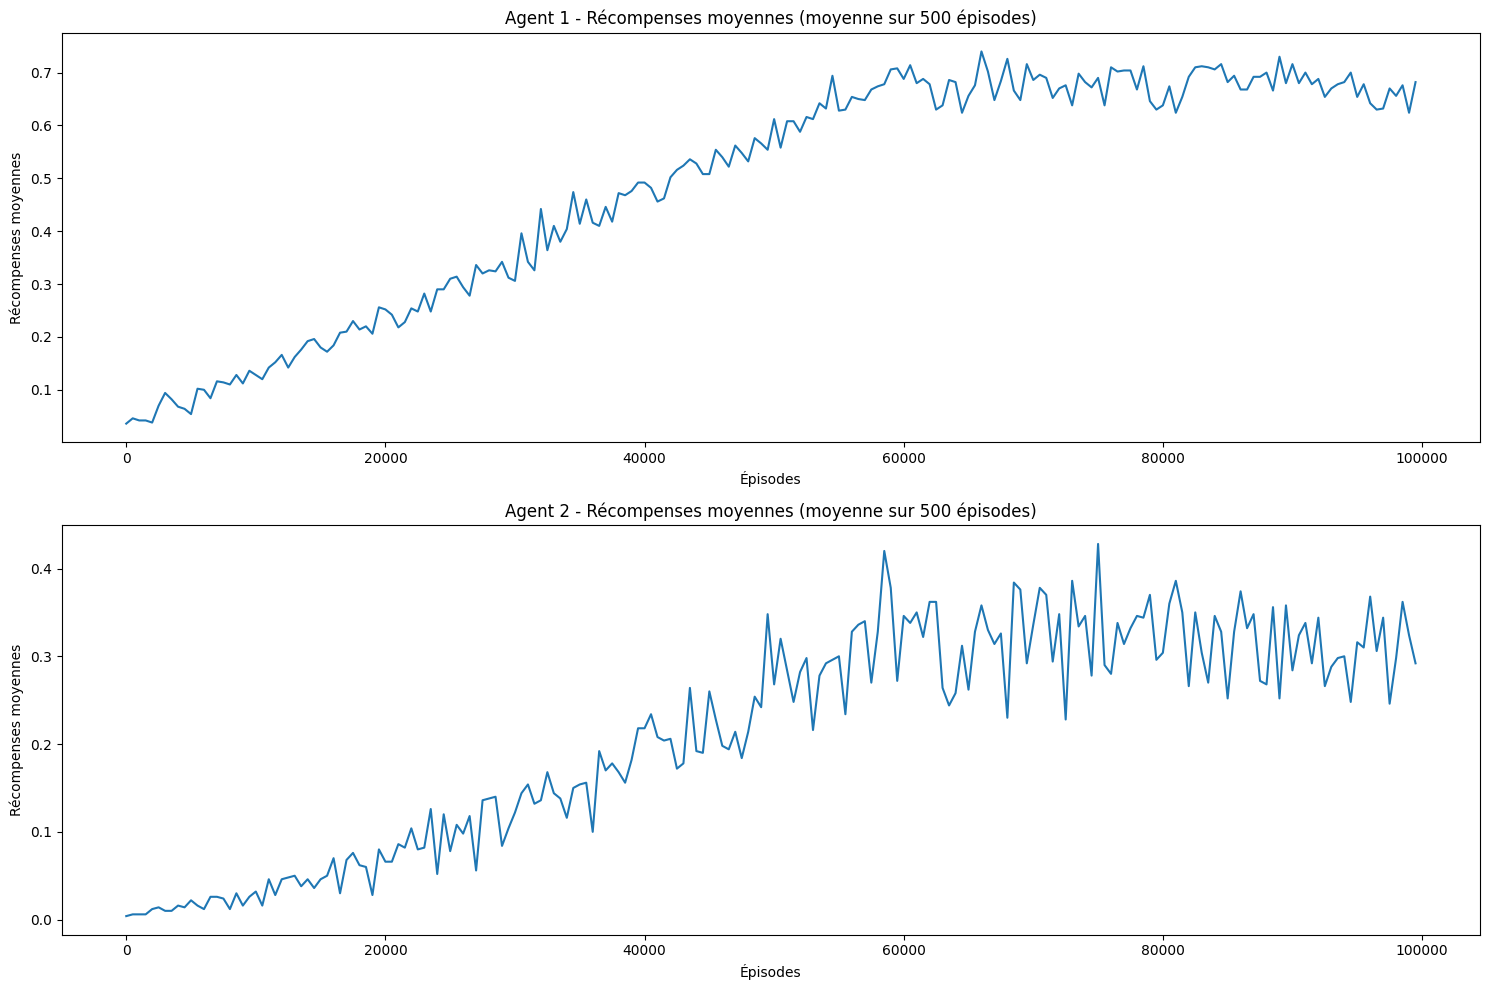

test of the obtained policy

Évaluation de la politique sur 1000 épisodes...

Résultats de l'évaluation:
Agent 1:
  - Taux de réussite: 92.40%
  - Nombre moyen d'étapes (succès): 32.86
  - Récompense moyenne: 0.9260
Agent 2:
  - Taux de réussite: 37.70%
  - Nombre moyen d'étapes (succès): 45.88
  - Récompense moyenne: 0.3790

Taux de collaboration: 0.20%


In [15]:

# env
env=FrozenLakeMultiAgentEnv(grid_size=(5, 5), slip_prob=0.33, hole_prob=0.2,seed=0)
#parameters
learning_rate = 0.3
max_episodes=100000
discount_factor = 0.99
exploration_rate = 1.0
min_exploration_rate = 0.05
exploration_decay = 0.99995
window_size=int(max_episodes/200)
iql,results=test_independent_learning(env,
                                      learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration_rate=min_exploration_rate,
        exploration_decay=exploration_decay,
        max_episodes=max_episodes,
        window_size=window_size)

# CQL

In [16]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class CentralizedQLearning:
    """
    Implémentation de l'apprentissage Q centralisé pour un environnement multi-agent.
    Supporte un nombre flexible d'agents.
    Utilise defaultdict pour une allocation efficace de la mémoire.
    """

    def __init__(self, env, n_agents=2, learning_rate=0.1, discount_factor=0.99,
                 exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay=0.995):
        """
        Initialise l'apprentissage Q centralisé.

        Args:
            env: Environnement multi-agent
            n_agents: Nombre d'agents
            learning_rate: Taux d'apprentissage (alpha)
            discount_factor: Facteur d'actualisation (gamma)
            exploration_rate: Taux d'exploration initial (epsilon)
            min_exploration_rate: Taux d'exploration minimal
            epsilon_decay: Taux de décroissance de l'exploration
        """
        self.env = env
        self.n_agents = n_agents
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.min_epsilon = min_exploration_rate
        self.epsilon_decay = exploration_decay

        # Obtenir les dimensions de l'espace d'action
        self.action_dims = []
        for i in range(n_agents):
            # Gère les deux façons possibles de représenter l'espace d'action
            if hasattr(env.action_space, '__getitem__'):
                self.action_dims.append(env.action_space[i].n)
            else:
                # Pour les espaces MultiDiscrete
                self.action_dims.append(4)  # Assume 4 actions (LEFT, DOWN, RIGHT, UP)

        # Table Q avec defaultdict pour allocation dynamique
        # Initialisation de la valeur par défaut
        self._setup_q_table()

    def _setup_q_table(self):
        """
        Configure la table Q en fonction du nombre d'agents.
        """
        def create_empty_q_values():
            # Crée dynamiquement un array numpy multidimensionnel pour stocker les valeurs Q
            return np.zeros(self.action_dims)

        self.q_table = defaultdict(create_empty_q_values)

    def get_action(self, states):
        """
        Sélectionne des actions pour tous les agents selon la politique epsilon-greedy.

        Args:
            states: Liste des états individuels des agents

        Returns:
            Liste des actions individuelles pour chaque agent
        """
        state_tuple = tuple(states)  # Convertir en tuple pour utiliser comme clé

        # Exploration-exploitation
        if np.random.random() < self.epsilon:
            # Actions aléatoires
            actions = [np.random.randint(0, self.action_dims[i]) for i in range(self.n_agents)]
        else:
            # Actions optimales selon la table Q
            joint_actions = np.unravel_index(
                np.argmax(self.q_table[state_tuple]),
                self.action_dims
            )
            actions = list(joint_actions)

        return actions

    def update(self, states, actions, rewards, next_states, dones):
        """
        Met à jour la table Q centralisée.

        Args:
            states: Liste des états individuels actuels
            actions: Liste des actions individuelles prises
            rewards: Liste des récompenses individuelles reçues
            next_states: Liste des états individuels suivants
            dones: Liste des drapeaux indiquant si les épisodes sont terminés
        """
        state_tuple = tuple(states)
        next_state_tuple = tuple(next_states)

        # Calculer la récompense totale
        total_reward = sum(rewards)

        # Vérifier si tous les agents ont terminé
        all_done = all(dones)

        # Créer un tuple d'index pour accéder à la valeur Q
        action_tuple = tuple(actions)

        # Valeur Q actuelle
        current_q = self.q_table[state_tuple][action_tuple]

        # Valeur future Q maximum (0 si terminé)
        if all_done:
            next_q = 0
        else:
            next_q = np.max(self.q_table[next_state_tuple])

        # Mise à jour Q-learning
        new_q = current_q + self.lr * (total_reward + self.gamma * next_q - current_q)
        self.q_table[state_tuple][action_tuple] = new_q

    def index_to_actions(self, joint_action):
        """
        Convertit un indice d'action jointe en actions individuelles.

        Args:
            joint_action: Indice d'action jointe

        Returns:
            list: Liste des actions individuelles pour chaque agent
        """
        # Pour un joint_action unique (index), retourne les actions individuelles
        return list(np.unravel_index(joint_action, self.action_dims))

    def state_to_index(self, states):
        """
        Convertit les états individuels des agents en une clé pour la table Q centralisée.

        Args:
            states: Liste des états individuels des agents

        Returns:
            tuple: Tuple d'états utilisable comme clé pour la table Q
        """
        return tuple(states)

    def decay_epsilon(self):
        """
        Réduit le taux d'exploration (epsilon) selon le taux de décroissance.
        """
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def render_policy(self):
        """
        Affiche des informations sur la politique apprise.
        """
        print("Politique centralisée:")

        # Calculer des statistiques sur la table Q
        n_states = len(self.q_table)

        if n_states == 0:
            print("Aucun état exploré.")
            return

        q_values = []
        for state, actions_q in self.q_table.items():
            q_values.extend(actions_q.flatten())

        q_values = np.array(q_values)
        nonzero_entries = np.count_nonzero(q_values)

        print(f"Nombre d'états visités: {n_states}")
        print(f"Nombre d'entrées Q non nulles: {nonzero_entries}")
        print(f"Valeur Q moyenne: {np.mean(q_values):.4f}")
        print(f"Valeur Q maximale: {np.max(q_values):.4f}")
        if nonzero_entries > 0:
            nonzero_q = q_values[q_values != 0]
            print(f"Valeur Q minimale (non-nulle): {np.min(nonzero_q):.4f}")
        else:
            print("Valeur Q minimale: N/A")

    def train(self, episodes=10000, max_steps=100, verbose=True):
        """
        Entraîne l'agent centralisé dans l'environnement multi-agent.

        Args:
            episodes: Nombre total d'épisodes d'entraînement
            max_steps: Nombre maximum d'étapes par épisode
            verbose: Si True, affiche la progression de l'entraînement

        Returns:
            Historique des récompenses par épisode
        """
        rewards_history = []
        rewards_rates = [[] for _ in range(self.n_agents)]
        episode_steps = []

        if verbose:
            episodes_iter = tqdm(range(episodes))
        else:
            episodes_iter = range(episodes)

        for episode in episodes_iter:
            # Réinitialiser l'environnement
            states, _ = self.env.reset()
            episode_rewards = [0] * self.n_agents
            dones = [False] * self.n_agents

            for step in range(max_steps):
                # Obtenir les actions
                actions = self.get_action(states)

                # Exécuter les actions dans l'environnement
                next_states, rewards, new_dones, truncated, _ = self.env.step(actions)

                # Mettre à jour la table Q
                self.update(states, actions, rewards, next_states, new_dones)

                # Accumuler les récompenses
                for i in range(self.n_agents):
                    if not dones[i]:
                        episode_rewards[i] += rewards[i]

                # Mettre à jour les états et les drapeaux terminés
                states = next_states
                dones = new_dones

                # Sortir de la boucle si tous les agents ont terminé
                if all(dones) or all(truncated):
                    break

            # Enregistrer les résultats de l'épisode
            rewards_history.append(episode_rewards)
            episode_steps.append(step + 1)

            # Enregistrer les récompenses pour chaque agent
            for i in range(self.n_agents):
                rewards_rates[i].append(episode_rewards[i])

            # Réduire epsilon
            self.decay_epsilon()

            # Afficher la progression
            if verbose and (episode + 1) % (episodes // 10) == 0:
                reward_window = 100
                recent_rewards = [
                    np.mean(rewards_rates[i][-min(reward_window, len(rewards_rates[i])):])
                    for i in range(self.n_agents)
                ]

                print(f"Épisode {episode + 1}/{episodes}, "
                      f"Récompenses moyennes agents: {[f'{reward:.2f}' for reward in recent_rewards]}, "
                      f"Epsilon: {self.epsilon:.4f}")

        return {
            'rewards': rewards_history,
            'rewards_rates': rewards_rates,
            'steps': episode_steps
        }

In [17]:
def test_centralized_learning(env,n_agents,
                              learning_rate = 0.3,
                              max_episodes=50000,
                              discount_factor = 0.99,
                              exploration_rate = 1.0,
                              min_exploration_rate = 0.05,
                              exploration_decay = 0.99995,
                              window_size=200):
    # Créer l'environnement
    # env = FrozenLakeMultiAgentEnv(grid_size=(5, 5), slip_prob=0., hole_prob=0.2)

    # Visualiser l'environnement initial
    print("Environnement initial:")
    env.render()

    # Paramètres d'apprentissage
    # learning_rate = 0.5
    # discount_factor = 0.99
    # exploration_rate = 1.5
    # min_exploration_rate = 0.05
    # exploration_decay = 0.99995

    # Créer l'instance d'apprentissage centralisé
    cql = CentralizedQLearning(
        env,
        n_agents=n_agents,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration_rate=min_exploration_rate,
        exploration_decay=exploration_decay
    )

    # Entraîner l'agent centralisé
    print("\nDébut de l'entraînement centralisé...")
    results = cql.train(episodes=max_episodes, max_steps=100)

    # Afficher la politique apprise
    print("\nPolitique centralisée apprise:")
    cql.render_policy()

    # Visualiser les résultats
    plt.figure(figsize=(15, 10))

    # Tracer les taux de récompense pour chaque agent
    window_size = 500
    for i in range(cql.n_agents):
        plt.subplot(cql.n_agents, 1, i+1)

        # Calculer les récompenses moyennes par fenêtre
        rewards_rates = results['rewards_rates'][i]
        rewards_rates_smoothed = []

        for j in range(0, len(rewards_rates), window_size):
            if j + window_size <= len(rewards_rates):
                rewards_rates_smoothed.append(np.mean(rewards_rates[j:j+window_size]))

        plt.plot(range(0, len(rewards_rates_smoothed) * window_size, window_size), rewards_rates_smoothed)
        plt.title(f"Agent {i+1} - Récompenses moyennes (moyenne sur {window_size} épisodes)")
        plt.xlabel("Épisodes")
        plt.ylabel("Récompenses moyennes")

    plt.tight_layout()
    plt.savefig("centralized_learning_results.png")
    plt.show()

    print('Test de la politique obtenue')
    eval_results = evaluate_policy(cql, env, n_episodes=1000, max_steps=100)

    return cql, results



Environnement initial:
A H . . .
. . H . .
. H . . .
. . . . H
G . H . A


Début de l'entraînement centralisé...


 10%|█         | 10475/100000 [00:03<00:20, 4381.38it/s]

Épisode 10000/100000, Récompenses moyennes agents: ['0.12', '0.01'], Epsilon: 0.9098


 21%|██        | 20753/100000 [00:05<00:15, 5259.35it/s]

Épisode 20000/100000, Récompenses moyennes agents: ['0.57', '0.20'], Epsilon: 0.5518


 31%|███       | 30659/100000 [00:06<00:12, 5710.73it/s]

Épisode 30000/100000, Récompenses moyennes agents: ['0.83', '0.54'], Epsilon: 0.3347


 41%|████▏     | 41260/100000 [00:08<00:08, 6934.14it/s]

Épisode 40000/100000, Récompenses moyennes agents: ['0.84', '0.69'], Epsilon: 0.2030


 51%|█████     | 50891/100000 [00:09<00:07, 6503.77it/s]

Épisode 50000/100000, Récompenses moyennes agents: ['0.89', '0.88'], Epsilon: 0.1231


 61%|██████    | 60909/100000 [00:11<00:05, 7002.20it/s]

Épisode 60000/100000, Récompenses moyennes agents: ['1.70', '1.66'], Epsilon: 0.0747


 71%|███████   | 71012/100000 [00:12<00:03, 7315.34it/s]

Épisode 70000/100000, Récompenses moyennes agents: ['1.81', '1.73'], Epsilon: 0.0500


 81%|████████  | 81016/100000 [00:14<00:03, 5030.60it/s]

Épisode 80000/100000, Récompenses moyennes agents: ['1.84', '1.79'], Epsilon: 0.0500


 91%|█████████ | 90871/100000 [00:16<00:01, 7025.22it/s]

Épisode 90000/100000, Récompenses moyennes agents: ['1.80', '1.76'], Epsilon: 0.0500


100%|██████████| 100000/100000 [00:17<00:00, 5669.23it/s]


Épisode 100000/100000, Récompenses moyennes agents: ['1.87', '1.87'], Epsilon: 0.0500

Politique centralisée apprise:
Politique centralisée:
Nombre d'états visités: 332
Nombre d'entrées Q non nulles: 2304
Valeur Q moyenne: 0.4883
Valeur Q maximale: 4.0000
Valeur Q minimale (non-nulle): 0.0022


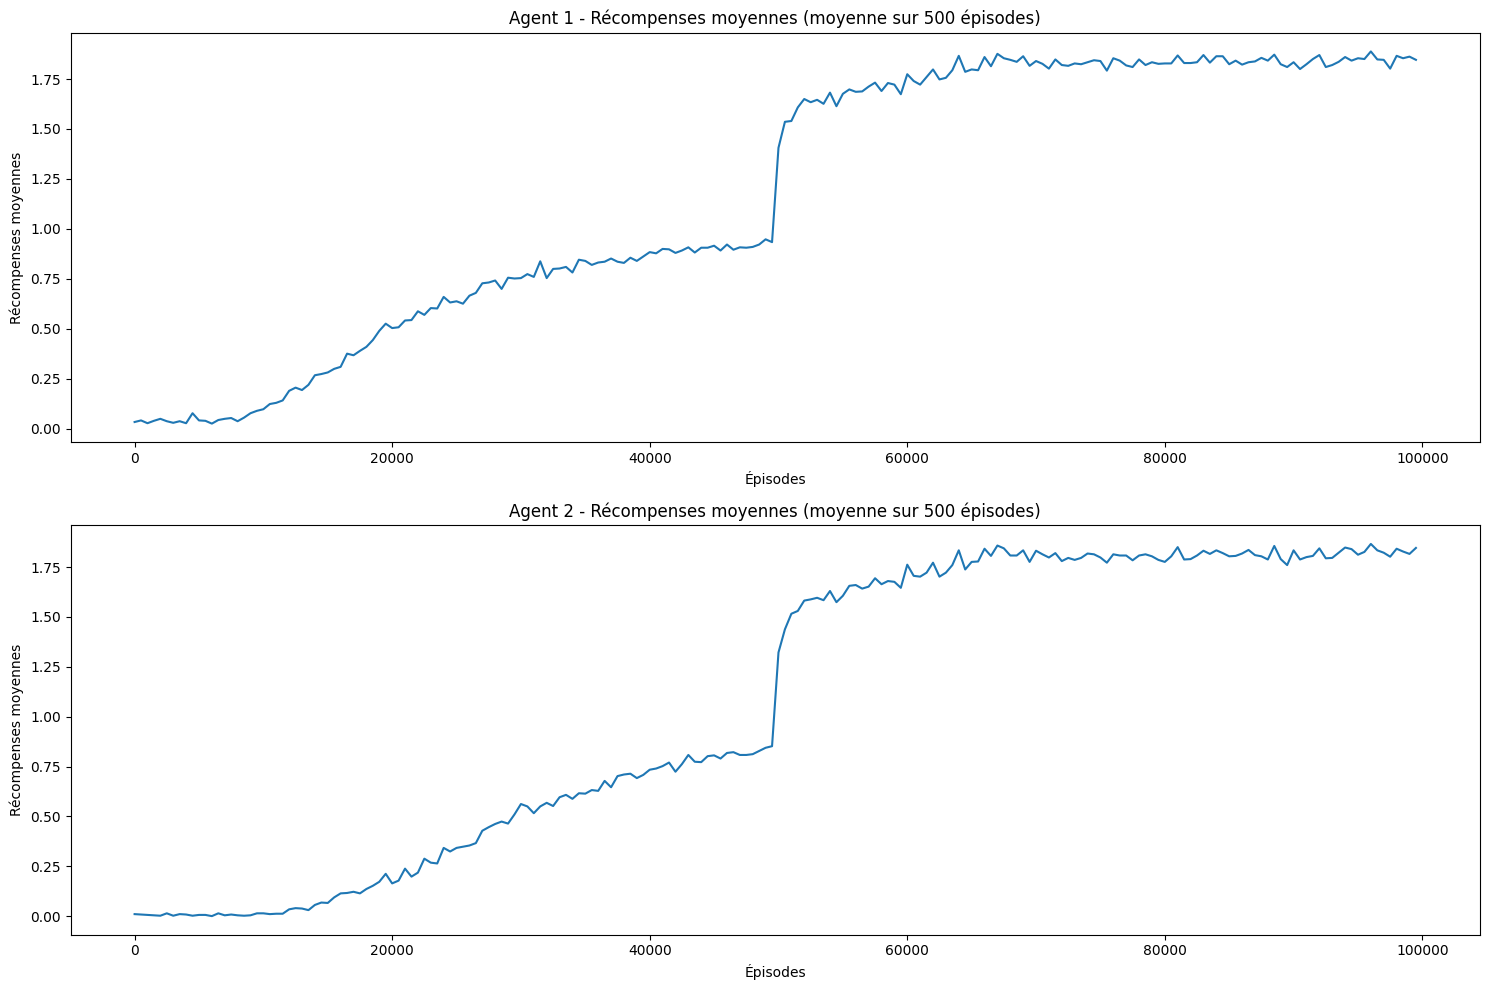

Test de la politique obtenue

Évaluation de la politique sur 1000 épisodes...

Résultats de l'évaluation:
Agent 1:
  - Taux de réussite: 100.00%
  - Nombre moyen d'étapes (succès): 6.00
  - Récompense moyenne: 2.0000
Agent 2:
  - Taux de réussite: 100.00%
  - Nombre moyen d'étapes (succès): 6.00
  - Récompense moyenne: 2.0000

Taux de collaboration: 100.00%


In [19]:
# env
env=FrozenLakeMultiAgentEnv(grid_size=(5, 5), slip_prob=0., hole_prob=0.2,seed=0)
#parameters
learning_rate = 0.5
max_episodes=100000
discount_factor = 0.99
exploration_rate = 1.5
min_exploration_rate = 0.05
exploration_decay = 0.99995
window_size=int(max_episodes/200)
cql,results=test_centralized_learning(env,n_agents=2,
                                      learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration_rate=min_exploration_rate,
        exploration_decay=exploration_decay,
        max_episodes=max_episodes,
        window_size=window_size)

In [ ]:
# iql,result=test_independent_learning(env)

# test

In [30]:
n_agents=2
env=FrozenLakeFlexibleAgentsEnv(num_agents=n_agents, grid_size=(5, 5), slip_prob=0., hole_prob=0.2, seed=7, collaboration_bonus=1.0)
env.render()
env.reset()

A . . . .
. H . H .
. . . . .
. H . H .
G . H . A



((0, 24), {})

Environnement initial:
A . . . .
. H . H .
. . . . .
. H . H .
G . H . A


Début de l'entraînement...


 10%|█         | 30634/300000 [00:07<00:56, 4797.66it/s]

Épisode 30000/300000, Récompenses moyennes agents: ['0.68', '0.39'], Epsilon: 0.4066


 20%|██        | 60792/300000 [00:13<00:47, 5059.55it/s]

Épisode 60000/300000, Récompenses moyennes agents: ['0.92', '0.67'], Epsilon: 0.1653


 30%|███       | 90642/300000 [00:19<00:36, 5732.92it/s]

Épisode 90000/300000, Récompenses moyennes agents: ['0.99', '0.96'], Epsilon: 0.0672


 40%|████      | 121253/300000 [00:25<00:27, 6395.75it/s]

Épisode 120000/300000, Récompenses moyennes agents: ['0.98', '0.89'], Epsilon: 0.0500


 50%|█████     | 150781/300000 [00:29<00:34, 4269.76it/s]

Épisode 150000/300000, Récompenses moyennes agents: ['1.00', '0.95'], Epsilon: 0.0500


 60%|██████    | 181081/300000 [00:35<00:18, 6384.82it/s]

Épisode 180000/300000, Récompenses moyennes agents: ['0.95', '0.93'], Epsilon: 0.0500


 70%|███████   | 210852/300000 [00:40<00:14, 6341.96it/s]

Épisode 210000/300000, Récompenses moyennes agents: ['0.97', '0.91'], Epsilon: 0.0500


 80%|████████  | 241065/300000 [00:46<00:09, 6352.40it/s]

Épisode 240000/300000, Récompenses moyennes agents: ['0.98', '0.90'], Epsilon: 0.0500


 90%|█████████ | 271074/300000 [00:51<00:04, 6211.91it/s]

Épisode 270000/300000, Récompenses moyennes agents: ['0.96', '0.91'], Epsilon: 0.0500


100%|██████████| 300000/300000 [00:56<00:00, 5295.37it/s]


Épisode 300000/300000, Récompenses moyennes agents: ['0.96', '0.92'], Epsilon: 0.0500

Politiques apprises:

Politique de l'agent 1:
 ↓  ←  ←  ←  ↓ 
 ↓  ←  ↓  ←  ↓ 
 ↓  ←  ←  ←  ← 
 ↓  ←  ↑  ←  ↑ 
 ←  ←  ←  →  ↑ 

Politique de l'agent 2:
 ↓  ←  ←  ←  ← 
 ↓  ←  ↓  ←  ↓ 
 ↓  ←  ←  ←  ← 
 ↓  ←  ↑  ←  ↑ 
 ←  ←  ←  →  ↑ 


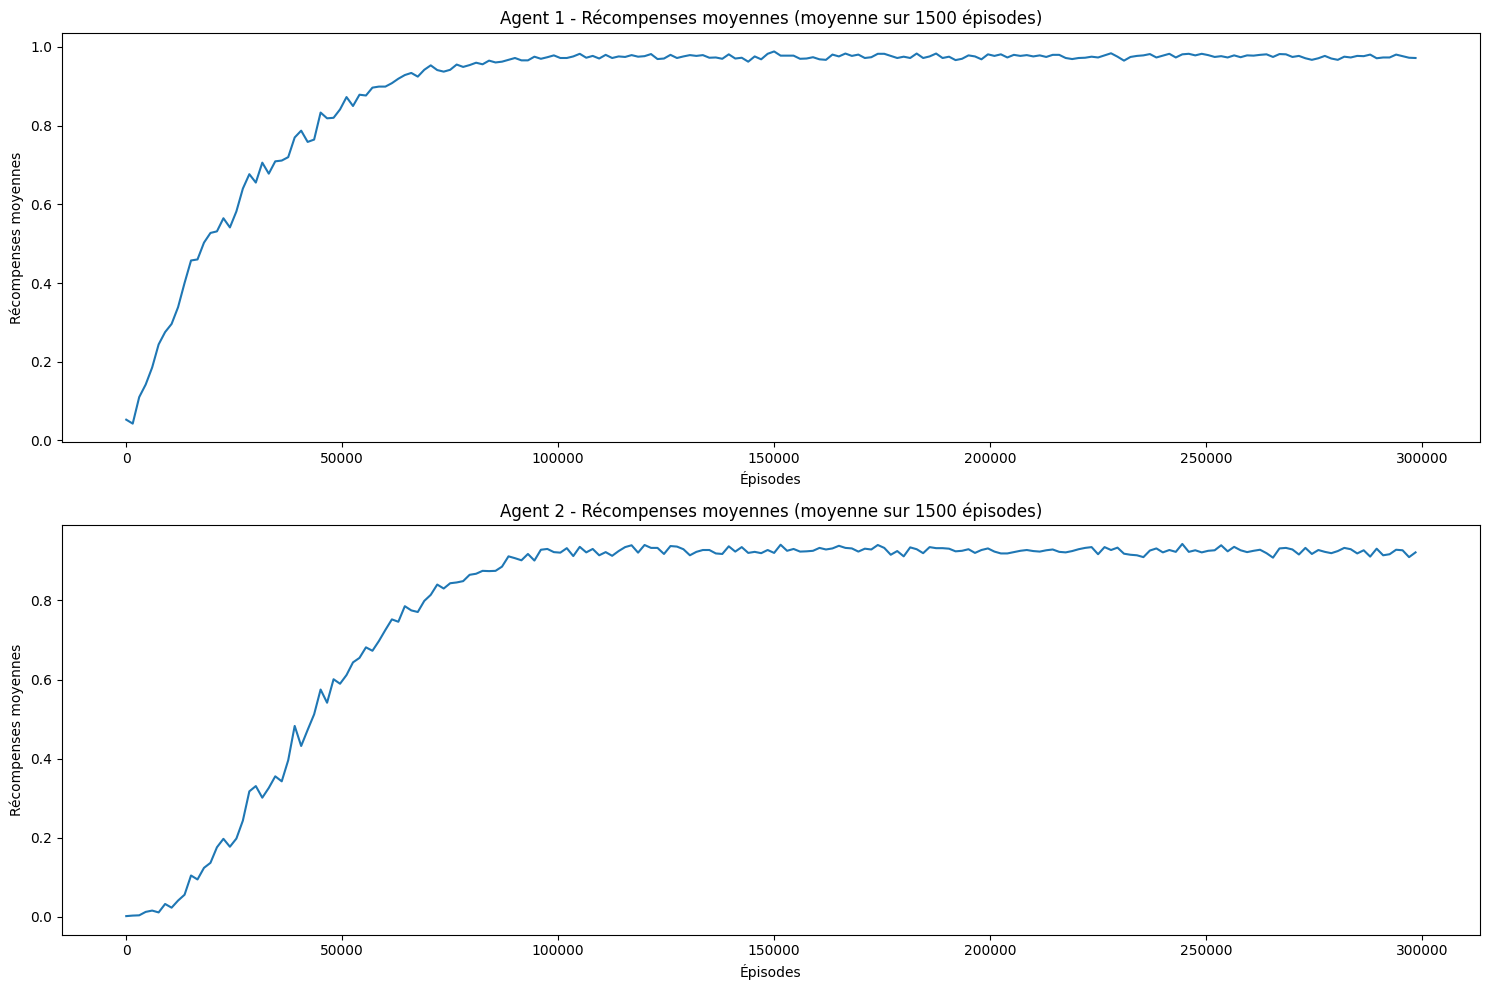

test of the obtained policy

Évaluation de la politique sur 1000 épisodes...

Résultats de l'évaluation:
Agent 1:
  - Taux de réussite: 100.00%
  - Nombre moyen d'étapes (succès): 4.00
  - Récompense moyenne: 1.0000
Agent 2:
  - Taux de réussite: 100.00%
  - Nombre moyen d'étapes (succès): 8.00
  - Récompense moyenne: 1.0000

Taux de collaboration: 0.00%


In [35]:
env.reset()
learning_rate = 0.5
max_episodes=300000
discount_factor = 0.99
exploration_rate = 1.
min_exploration_rate = 0.05
exploration_decay = 0.99997
window_size=int(max_episodes/200)

iql,results=test_independent_learning(env,n_agents=n_agents,
                                      learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration_rate=min_exploration_rate,
        exploration_decay=exploration_decay,
        max_episodes=max_episodes,
        window_size=window_size)

Environnement initial:
A . . . .
. H . H .
. . . . .
. H . H .
G . H . A


Début de l'entraînement centralisé...


 10%|█         | 30352/300000 [00:07<01:36, 2786.63it/s]

Épisode 30000/300000, Récompenses moyennes agents: ['0.10', '0.01'], Epsilon: 0.8607


 20%|██        | 60523/300000 [00:16<01:11, 3366.51it/s]

Épisode 60000/300000, Récompenses moyennes agents: ['0.32', '0.02'], Epsilon: 0.7408


 30%|███       | 90580/300000 [00:26<00:59, 3528.95it/s]

Épisode 90000/300000, Récompenses moyennes agents: ['0.42', '0.10'], Epsilon: 0.6376


 40%|████      | 120522/300000 [00:35<00:59, 3024.81it/s]

Épisode 120000/300000, Récompenses moyennes agents: ['0.51', '0.14'], Epsilon: 0.5488


 50%|█████     | 150764/300000 [00:43<00:38, 3904.09it/s]

Épisode 150000/300000, Récompenses moyennes agents: ['0.66', '0.24'], Epsilon: 0.4724


 60%|██████    | 180479/300000 [00:52<00:34, 3427.77it/s]

Épisode 180000/300000, Récompenses moyennes agents: ['0.63', '0.34'], Epsilon: 0.4066


 70%|███████   | 210397/300000 [01:02<00:28, 3116.57it/s]

Épisode 210000/300000, Récompenses moyennes agents: ['0.99', '0.71'], Epsilon: 0.3499


 80%|████████  | 240426/300000 [01:11<00:24, 2431.12it/s]

Épisode 240000/300000, Récompenses moyennes agents: ['1.00', '0.79'], Epsilon: 0.3012


 90%|█████████ | 270736/300000 [01:20<00:07, 3862.27it/s]

Épisode 270000/300000, Récompenses moyennes agents: ['1.15', '0.94'], Epsilon: 0.2592


100%|██████████| 300000/300000 [01:29<00:00, 3370.61it/s]


Épisode 300000/300000, Récompenses moyennes agents: ['1.30', '1.17'], Epsilon: 0.2231

Politique centralisée apprise:
Politique centralisée:
Nombre d'états visités: 496
Nombre d'entrées Q non nulles: 4632
Valeur Q moyenne: 0.9034
Valeur Q maximale: 4.0000
Valeur Q minimale (non-nulle): 0.0027


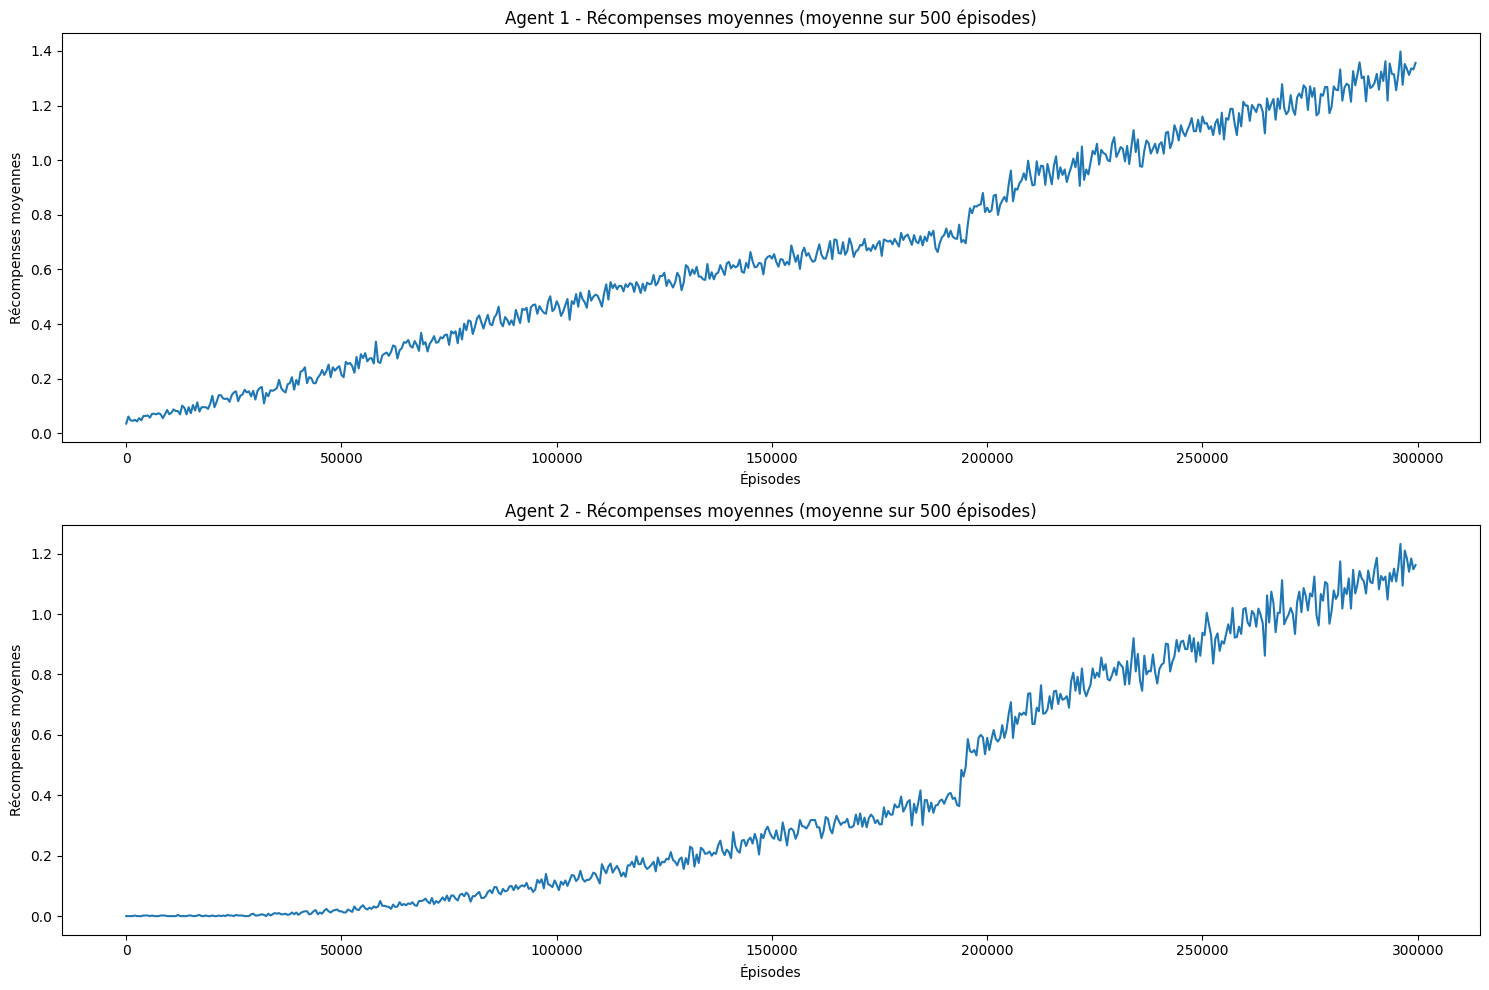

Test de la politique obtenue

Évaluation de la politique sur 1000 épisodes...

Résultats de l'évaluation:
Agent 1:
  - Taux de réussite: 100.00%
  - Nombre moyen d'étapes (succès): 8.00
  - Récompense moyenne: 2.0000
Agent 2:
  - Taux de réussite: 100.00%
  - Nombre moyen d'étapes (succès): 8.00
  - Récompense moyenne: 2.0000

Taux de collaboration: 100.00%


In [32]:
env.reset()
learning_rate = 0.5
max_episodes=300000
discount_factor = 0.99
exploration_rate = 1
min_exploration_rate = 0.05
exploration_decay = 0.999995
window_size=int(max_episodes/200)

cql,results=test_centralized_learning(env,n_agents=n_agents,
                                      learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration_rate=min_exploration_rate,
        exploration_decay=exploration_decay,
        max_episodes=max_episodes,
        window_size=window_size)

# DQN

A . . . .
. H . H .
. . . . .
. H . H .
G . H . A

Épisode 1/3000, Récompense moyenne: 0.00, Perte moyenne: 0.0000
Épisode 200/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0013
Épisode 400/3000, Récompense moyenne: 0.00, Perte moyenne: 0.0011
Épisode 600/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0013
Épisode 800/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0000
Épisode 1000/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0004
Épisode 1200/3000, Récompense moyenne: 0.00, Perte moyenne: 0.0008
Épisode 1400/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0017
Épisode 1600/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0005
Épisode 1800/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0000
Épisode 2000/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0029
Épisode 2200/3000, Récompense moyenne: 0.00, Perte moyenne: 0.0001
Épisode 2400/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0000
Épisode 2600/3000, Récompense moyenne: 0.50, Perte moyenne: 0.0000
Épisode 2800/3000,

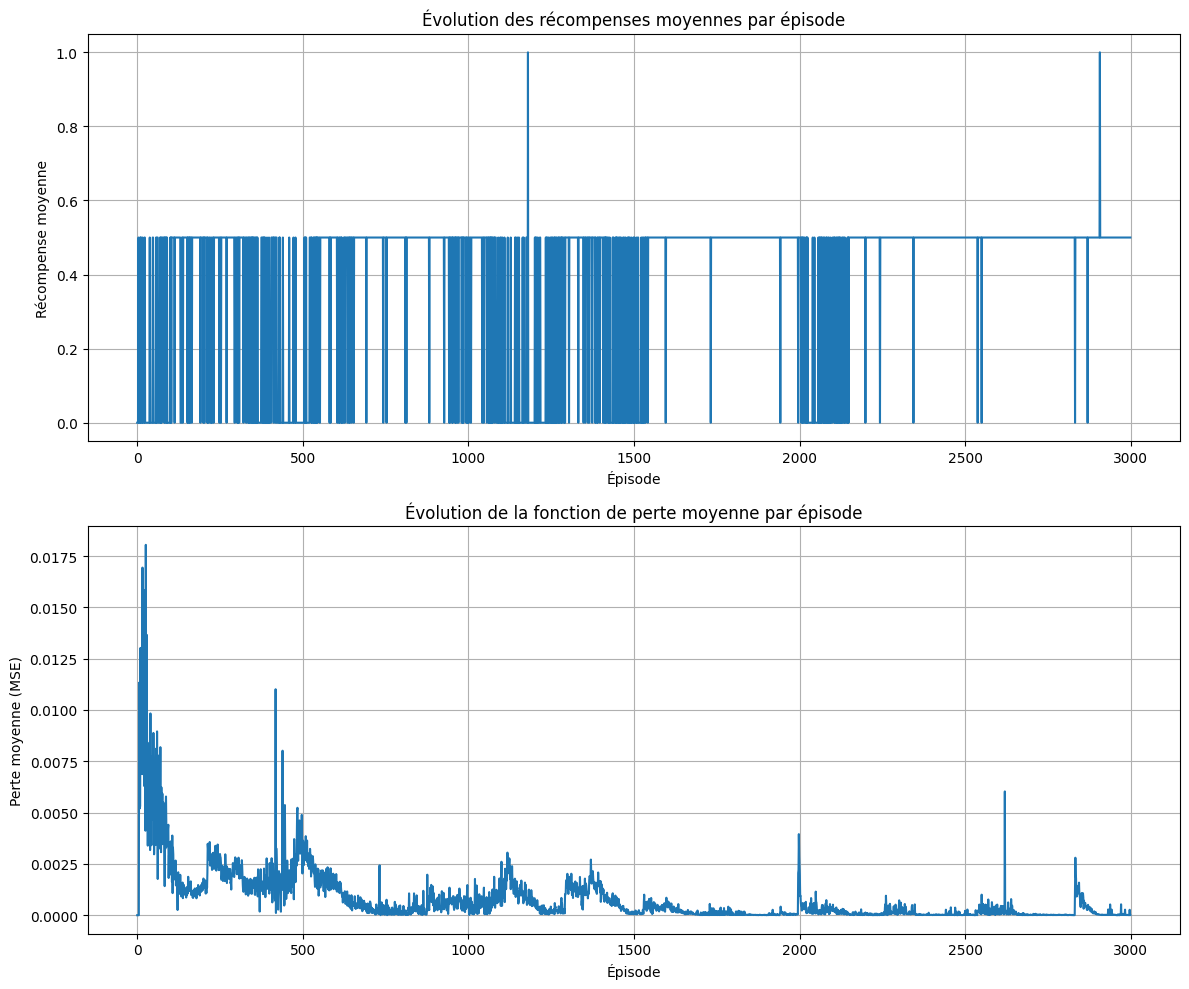

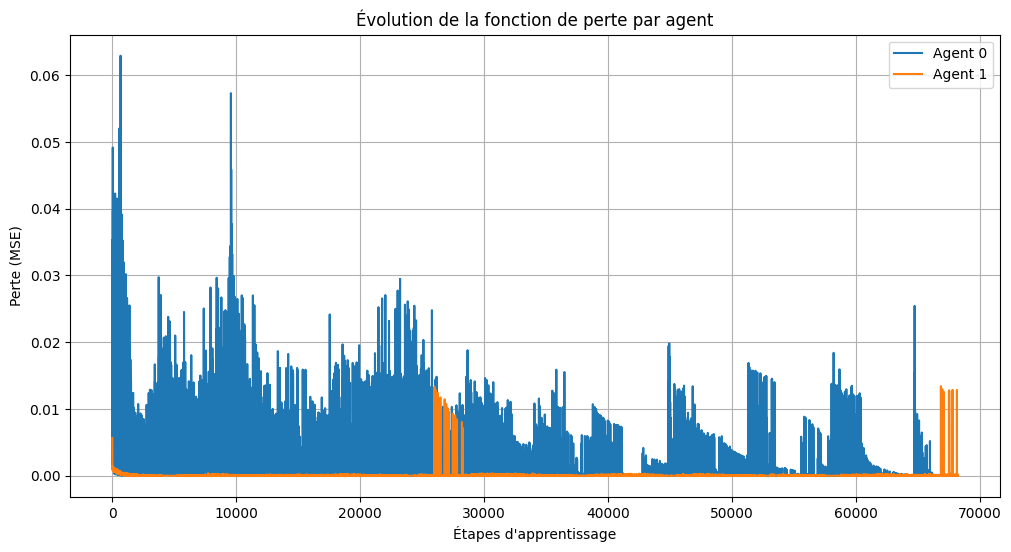


Test épisode 1/5:
A . . . .
. H . H .
. . . . .
. H . H .
G . H . A

Step 1: Actions=[1, 0], Rewards=[0, 0]
. . . . .
A H . H .
. . . . .
. H . H .
G . H A .

Step 2: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
A . . . .
. H . H .
G . H . A

Step 3: Actions=[1, 0], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
A H . H .
G . H A .

Step 4: Actions=[1, 1], Rewards=[1, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H A .

Step 5: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H . A

Step 6: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H . A

Step 7: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H . A

Step 8: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H . A

Step 9: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H . A

Step 10: Actions=[1, 2], Rewards=[0, 0]
. . . . .
. H . H .
. . . . .
. H . H .
A . H . A

Step 11: Actions=[1, 2], Rewa

In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

# DQN Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay Memory
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = Experience

    def add(self, state, action, reward, next_state, done):
        e = self.experiences(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# DQN Agent with Loss Tracking
class DQNAgent:
    def __init__(self, state_size, action_size, agent_id, seed=0):
        self.state_size = state_size
        self.action_size = action_size
        self.agent_id = agent_id
        self.seed = random.seed(seed)

        # Q-Networks (current and target)
        self.qnetwork_local = DQN(state_size, action_size)
        self.qnetwork_target = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)

        # Replay memory
        self.buffer_size = 10000
        self.batch_size = 64
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)

        # Learning parameters
        self.gamma = 0.99            # discount factor
        self.tau = 1e-3              # for soft update of target parameters
        self.update_every = 4        # how often to update the network
        self.epsilon = 1.0           # exploration rate
        self.epsilon_min = 0.01      # minimum exploration rate
        self.epsilon_decay = 0.995   # decay rate for exploration
        self.step_counter = 0

        # Loss tracking
        self.losses = []

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Increment step counter
        self.step_counter += 1

        # Learn every update_every time steps
        if self.step_counter % self.update_every == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                return self.learn(experiences)
        return None

    def act(self, state, epsilon=None):
        """Returns actions for given state as per current policy."""
        if epsilon is None:
            epsilon = self.epsilon

        # Convert state to PyTorch tensor
        state = torch.from_numpy(state).float().unsqueeze(0)

        # Set the network to evaluation mode
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)

        # Set the network back to training mode
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples."""
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Store the loss value
        loss_value = loss.item()
        self.losses.append(loss_value)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss_value

    def soft_update(self, local_model, target_model):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

# Multi-Agent IQL Manager with Loss Tracking
class MultiAgentIQL:
    def __init__(self, env, **kwargs):
        self.env = env
        self.num_agents = env.num_agents

        # Calculer la taille de l'espace d'états pour un agent
        # Grid size * nombre d'agents pour inclure les positions des autres agents
        self.grid_cells = env.grid_size[0] * env.grid_size[1]
        self.state_size = self.num_agents  # Un état par agent (sa position et celles des autres)
        self.action_size = 4  # 4 actions (gauche, bas, droite, haut)

        # Créer plusieurs agents
        self.agents = [DQNAgent(self.state_size, self.action_size, i, **kwargs)
                      for i in range(self.num_agents)]

        # Suivi des scores et pertes
        self.scores = []
        self.episode_rewards = []
        self.all_losses = []  # Track losses for all agents

    def _encode_state(self, state_tuple):
        """Convertir l'état global en états individuels pour chaque agent"""
        # state_tuple contient les indices des positions de chaque agent

        # Normaliser les positions des agents pour l'entrée du réseau
        normalized_states = np.array(state_tuple) / self.grid_cells

        # Créer une représentation d'état pour chaque agent
        agent_states = []
        for i in range(self.num_agents):
            # Inclure les positions de tous les agents dans l'état de chaque agent
            agent_state = normalized_states.copy()
            agent_states.append(agent_state)

        return agent_states

    def train(self, num_episodes=1000, max_steps=100, print_every=100):
        """Entraîner tous les agents avec IQL."""
        all_rewards = []
        episode_losses = []  # Track losses per episode

        for episode in range(1, num_episodes+1):
            state_tuple, _ = self.env.reset()
            agent_states = self._encode_state(state_tuple)
            episode_rewards = np.zeros(self.num_agents)

            # Track losses for this episode
            ep_losses = []

            for step in range(max_steps):
                # Obtenir des actions de tous les agents
                actions = []
                for i, agent in enumerate(self.agents):
                    action = agent.act(agent_states[i])
                    actions.append(action)

                # Prendre les actions dans l'environnement
                next_state_tuple, rewards, dones, truncated, _ = self.env.step(actions)
                next_agent_states = self._encode_state(next_state_tuple)

                # Mettre à jour l'expérience de chaque agent et collecter les pertes
                for i, agent in enumerate(self.agents):
                    loss = agent.step(agent_states[i], actions[i], rewards[i], next_agent_states[i], dones[i] or truncated[i])
                    if loss is not None:
                        ep_losses.append(loss)

                # Mettre à jour les récompenses totales
                episode_rewards += np.array(rewards)

                # Vérifier si l'épisode est terminé pour tous les agents ou si la limite de temps est atteinte
                if all(dones) or all(truncated):
                    break

                # Mettre à jour les états pour la prochaine étape
                agent_states = next_agent_states

            # Suivre les scores
            avg_reward = np.mean(episode_rewards)
            all_rewards.append(avg_reward)
            self.episode_rewards.append(episode_rewards)

            # Calculate average loss for this episode
            if ep_losses:
                avg_loss = np.mean(ep_losses)
                episode_losses.append(avg_loss)
            else:
                episode_losses.append(0)

            # Afficher la progression
            if episode % print_every == 0 or episode == 1:
                avg_loss_val = np.mean(ep_losses) if ep_losses else 0
                print(f'Épisode {episode}/{num_episodes}, Récompense moyenne: {avg_reward:.2f}, Perte moyenne: {avg_loss_val:.4f}')

        self.scores = all_rewards
        self.all_losses = episode_losses
        return all_rewards, episode_losses

    def test(self, num_episodes=10, render=True):
        """Tester les agents entraînés"""
        test_rewards = []

        for episode in range(num_episodes):
            state_tuple, _ = self.env.reset()
            agent_states = self._encode_state(state_tuple)
            episode_rewards = np.zeros(self.num_agents)
            done = [False] * self.num_agents

            if render:
                print(f"\nTest épisode {episode+1}/{num_episodes}:")
                self.env.render()

            step = 0
            while not all(done) and step < 100:
                step += 1
                # Utiliser les politiques apprises (pas d'exploration)
                actions = []
                for i, agent in enumerate(self.agents):
                    action = agent.act(agent_states[i], epsilon=0.0)  # epsilon=0 pour le test
                    actions.append(action)

                next_state_tuple, rewards, dones, truncated, info = self.env.step(actions)
                done = [d or t for d, t in zip(dones, truncated)]

                if render:
                    print(f"Step {step}: Actions={actions}, Rewards={rewards}")
                    self.env.render()

                # Mettre à jour les récompenses et les états
                episode_rewards += np.array(rewards)
                agent_states = self._encode_state(next_state_tuple)

            test_rewards.append(np.mean(episode_rewards))
            print(f"Test épisode {episode+1} terminé. Récompense totale: {np.mean(episode_rewards):.2f}")

            if 'simultaneous_arrival' in info and info['simultaneous_arrival']:
                print(f"Arrivée simultanée! {info['num_simultaneous_arrivals']} agents sont arrivés en même temps.")
                print(f"Bonus progressif: {info['progressive_bonus']}")

        return test_rewards

    def plot_rewards(self):
        """Tracer l'évolution des récompenses pendant l'entraînement"""
        plt.figure(figsize=(12, 10))

        # Plot rewards
        plt.subplot(2, 1, 1)
        plt.plot(self.scores)
        plt.title('Évolution des récompenses moyennes par épisode')
        plt.xlabel('Épisode')
        plt.ylabel('Récompense moyenne')
        plt.grid(True)

        # Plot losses
        plt.subplot(2, 1, 2)
        plt.plot(self.all_losses)
        plt.title('Évolution de la fonction de perte moyenne par épisode')
        plt.xlabel('Épisode')
        plt.ylabel('Perte moyenne (MSE)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_agent_losses(self):
        """Tracer l'évolution des pertes individuelles pour chaque agent"""
        plt.figure(figsize=(12, 6))
        for i, agent in enumerate(self.agents):
            if agent.losses:  # Only plot if there are losses recorded
                plt.plot(agent.losses, label=f'Agent {i}')

        plt.title('Évolution de la fonction de perte par agent')
        plt.xlabel('Étapes d\'apprentissage')
        plt.ylabel('Perte (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Code d'exemple pour l'entraînement et le test
def train_and_test_agents(env_params=None, training_params=None):
    if env_params is None:
        env_params = {
            'num_agents': 2,
            'grid_size': (5, 5),
            'slip_prob': 0.2,
            'hole_prob': 0.1,
            'collaboration_bonus': 2.0,
            'seed': 7
        }

    if training_params is None:
        training_params = {
            'num_episodes': 2000,
            'max_steps': 100,
            'print_every': 100
        }

    # Créer l'environnement
    env = FrozenLakeFlexibleAgentsEnv(**env_params)
    env.render()
    # Créer et entraîner les agents
    ma_iql = MultiAgentIQL(env, seed=env_params['seed'])
    rewards, losses = ma_iql.train(**training_params)

    # Afficher les performances d'entraînement
    ma_iql.plot_rewards()

    # Afficher les pertes individuelles par agent
    ma_iql.plot_agent_losses()

    # Tester les agents entraînés
    test_rewards = ma_iql.test(num_episodes=5, render=True)

    print("\nRésultats des tests:")
    print(f"Récompense moyenne sur les épisodes de test: {np.mean(test_rewards):.2f}")

    return ma_iql

if __name__ == "__main__":
    # Vous pouvez personnaliser ces paramètres
    env_params = {
        'num_agents': 2,           # Nombre d'agents
        'grid_size': (5, 5),       # Taille de la grille
        'slip_prob': 0.0,          # Probabilité de glisser
        'hole_prob': 0.2,          # Probabilité de trous
        'collaboration_bonus': 1.0, # Bonus de collaboration
        'seed': 7                 # Graine aléatoire
    }

    training_params = {
        'num_episodes': 3000,      # Nombre d'épisodes d'entraînement
        'max_steps': 100,          # Nombre maximum d'étapes par épisode
        'print_every': 200         # Fréquence d'affichage
    }

    ma_iql = train_and_test_agents(env_params, training_params)

ModuleNotFoundError: No module named 'multi_agent_frozen'

In [1]:
# Example usage
if __name__ == "__main__":
    n_agents=2
    CQL=True
    IQL=True
    # Example map string for FrozenLakeFlexibleAgentsEnvCol
    # A = agent start, G = goal, H = hole, . or F = frozen surface
    flexible_map = "....H..A/A...H.../...H..../.....H../...H..../HHH...H./.H..H.H./...H...G"
    
 
    
    
    # Create environments from the maps
    env = create_map_from_string(flexible_map, "flexible")
    env.render()
    env.reset()

NameError: name 'create_map_from_string' is not defined

# Animation

In [ ]:
import numpy as np
import gym
import time
import os
import glob
import base64
import IPython
from IPython.display import HTML
import imageio

def record_video(env, policy, horizon, video_path="./video"):
    """
    Records an episode of the environment following the given policy.
    """
    os.makedirs(video_path, exist_ok=True)
    env = gym.wrappers.RecordVideo(env, video_path)
    state = env.reset()
    for t in range(horizon):
        action = policy[t][state]
        state, _, done, _ = env.step(action)
        if done:
            break
    env.close()

def show_video(video_path="./video"):
    """
    Displays the recorded video inside a Colab notebook.
    """
    video_files = glob.glob(video_path + "/*.mp4")
    if len(video_files) == 0:
        print("No videos found!")
        return

    video_path = video_files[-1]  # Get the last recorded video

    video = open(video_path, "rb").read()
    video_encoded = base64.b64encode(video).decode("utf-8")
    video_tag = f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_encoded}" type="video/mp4"></video>'

    return IPython.display.HTML(video_tag)

class FiniteHorizonMDP:
    def __init__(self, env, horizon, gamma=1.0):
        self.env = env  # OpenAI Gym environment
        self.horizon = horizon  # Time horizon
        self.gamma = gamma  # Discount factor
        self.states = env.observation_space.n
        self.actions = env.action_space.n
        self.V = np.zeros((horizon + 1, self.states))  # Value function
        self.policy = np.zeros((horizon, self.states), dtype=int)  # Policy

    def value_iteration(self):
        for t in reversed(range(self.horizon)):
            for s in range(self.states):
                best_value = float('-inf')
                best_action = None

                for a in range(self.actions):
                    value = 0
                    for prob, s_next, reward, _ in self.env.P[s][a]:
                        value += prob * (reward + self.gamma * self.V[t + 1][s_next])

                    if value > best_value:
                        best_value = value
                        best_action = a

                self.V[t][s] = best_value
                self.policy[t][s] = best_action

    def get_policy(self):
        return self.policy

    def get_value_function(self):
        return self.V

    def visualize_policy(self):
        record_video(self.env, self.policy, self.horizon)
        return show_video()

# OpenAI Gym FrozenLake-v1 Test
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")  # Deterministic version
horizon = 10  # 10 time steps
gamma = 0.9

mdp = FiniteHorizonMDP(env, horizon, gamma)
mdp.value_iteration()

# Display Results
print("Optimal Policy:")
print(mdp.get_policy())
print("\nValue Function:")
print(mdp.get_value_function())

# Visualize Optimal Policy Execution
mdp.visualize_policy()
